# 定义数据增强类

In [12]:
import torch
import torch.nn as nn

class TimeSeriesPerturbation(nn.Module):
    def __init__(self, scale_factor=2, truncate_ratio=0.3, 
                 noise_snr_range=5, shift_range=50, speed_scale_factor=2,
                 amplitude_mod_factor=0.2, fault_amp_ratio=0.5, fault_freq_ratio=1.0):
        """
        :param scale_factor: 统一缩放因子，(1/scale_factor, scale_factor) 代替 (0.5, 2)
        :param speed_scale_factor: 变速因子，(1/speed_scale_factor, speed_scale_factor) 代替 (0.8, 1.2)
        :param noise_snr_range: 高斯噪声 SNR 范围（单值，自动扩展）
        :param shift_range: 时间偏移范围
        :param amplitude_mod_factor: 振幅调制因子
        :param fault_amp_ratio: 故障冲击幅度比例（基于信号 RMS）
        :param fault_freq_ratio: 故障冲击频率比例（基于信号主频）
        """
        super(TimeSeriesPerturbation, self).__init__()
        self.scaling_range = (1/scale_factor, scale_factor)
        self.speed_scale_range = (1/speed_scale_factor, speed_scale_factor)
        self.truncate_ratio = truncate_ratio
        self.noise_snr_range = (noise_snr_range, noise_snr_range + 3)
        self.shift_range = shift_range
        self.amplitude_mod_factor = amplitude_mod_factor
        self.fault_amp_ratio = fault_amp_ratio
        self.fault_freq_ratio = fault_freq_ratio

    ## **1. 计算信号的 RMS 和主频**
    def compute_signal_features(self, signal):
        """ 计算信号的 RMS（均方根值）和主频 """
        B, L, M = signal.shape
        rms = torch.sqrt(torch.mean(signal ** 2, dim=1, keepdim=True))  # 计算 RMS
        freqs = torch.fft.rfftfreq(L)  # 计算频率分布
        fft_magnitude = torch.abs(torch.fft.rfft(signal, dim=1))  # 计算 FFT 幅值
        main_freq = freqs[torch.argmax(fft_magnitude, dim=1, keepdim=True)]  # 取最大频率成分
        return rms, main_freq

    ## **2. 工况增强**
    def time_shift(self, signal):
        """ 时间偏移：模拟不同采样工况 """
        shift = torch.randint(-self.shift_range, self.shift_range, (1,)).item()
        return torch.roll(signal, shifts=shift, dims=1)

    def speed_scale(self, signal):
        """ 变速增强：模拟不同转速工况 """
        B, L, M = signal.shape
        min_speed, max_speed = self.speed_scale_range
        scale_factors = torch.FloatTensor(B, 1, 1).uniform_(min_speed, max_speed).to(signal.device)
        new_L = int(L * scale_factors.mean().item())
        signal = torch.nn.functional.interpolate(signal, size=new_L, mode='linear', align_corners=False)
        return torch.nn.functional.interpolate(signal, size=L, mode='linear', align_corners=False)

    ## **3. 故障增强**
    def amplitude_modulation(self, signal):
        """ 调幅增强：模拟信号调制故障 """
        B, L, M = signal.shape
        rms, main_freq = self.compute_signal_features(signal)  # 计算 RMS 和主频
        mod_freq = main_freq * self.fault_freq_ratio  # 调制频率基于主频
        mod_amp = self.amplitude_mod_factor * rms  # 振幅基于 RMS
        time = torch.arange(L, device=signal.device).float().view(1, -1, 1)
        mod_wave = 1 + mod_amp * torch.cos(2 * torch.pi * mod_freq * time / L)
        return signal * mod_wave

    def fault_impact(self, signal):
        """ 故障冲击增强：模拟轴承或齿轮缺陷 """
        B, L, M = signal.shape
        rms, main_freq = self.compute_signal_features(signal)  # 计算 RMS 和主频
        fault_amp = self.fault_amp_ratio * rms  # 冲击幅度基于 RMS
        fault_freq = main_freq * self.fault_freq_ratio  # 冲击频率基于主频
        time = torch.arange(L, device=signal.device).float().view(1, -1, 1)
        impact_wave = fault_amp * torch.exp(-0.01 * time) * torch.cos(2 * torch.pi * fault_freq * time / L)
        return signal + impact_wave

    ## **4. 设备增强**
    def scale_values(self, signal):
        """ 振幅缩放：模拟不同设备的信号放大或缩小 """
        B = signal.shape[0]
        min_scale, max_scale = self.scaling_range
        scale_factors = torch.FloatTensor(B, 1, 1).uniform_(min_scale, max_scale).to(signal.device)
        return signal * scale_factors

    def add_gaussian_noise(self, signal):
        """ 添加高斯噪声：模拟设备测量噪声 """
        B = signal.shape[0]
        min_snr, max_snr = self.noise_snr_range
        snr_db = torch.FloatTensor(B, 1, 1).uniform_(min_snr, max_snr).to(signal.device)
        signal_power = torch.mean(signal ** 2, dim=1, keepdim=True)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise = torch.randn_like(signal) * torch.sqrt(noise_power)
        return signal + noise

    def truncate(self, signal):
        """ 频域截断：模拟设备不同传感器的频率响应差异 """
        B, L, M = signal.shape
        freq_signal = torch.fft.rfft(signal, dim=1)
        freq_len = freq_signal.shape[1]
        rand_mask = torch.rand(B, freq_len, M, device=signal.device)
        mask = (rand_mask > self.truncate_ratio).float()
        masked_freq_signal = freq_signal * mask
        return torch.fft.irfft(masked_freq_signal, n=L, dim=1)

    ## **5. 选择增强策略**
    def forward(self, signal, mode=None):
        """
        选择增强策略：
        - "auto": 随机选择一种（工况增强、故障增强、设备增强）
        - "condition": 仅进行工况增强
        - "fault": 仅进行故障增强
        - "device": 仅进行设备增强
        """
        if mode is None:
            modes = ["condition", "fault", "device"]
            idx = torch.randint(0, len(modes), (1,)).item()
            mode = modes[idx]

        if mode == "condition":
            signal = self.time_shift(signal)
            signal = self.speed_scale(signal)

        elif mode == "fault":
            signal = self.fault_impact(signal)
            signal = self.amplitude_modulation(signal)

        elif mode == "device":
            signal = self.scale_values(signal)
            signal = self.add_gaussian_noise(signal)
            signal = self.truncate(signal)

        return signal


# 实例化类，读入真实数据集

In [2]:
from data_provider.data_loader import *
# from data_provider.DG_data_loader import *
# from torch.utils.data import DataLoader, Subset
import argparse    
parser = argparse.ArgumentParser(description='RmGPT supervised training')
parser.add_argument('--task_name', type=str, required=False, default='few_shot',
                    help='task name')
parser.add_argument('--shot_num', type=int, required=False, default='1',
                    help='sample number per class')
args, unknown = parser.parse_known_args()
root_path = '/dataYYF/dataWX/WYL/PHM-Large-Model/PHM_dataset/CWRU'
# args.task_name = 'all'
print('*'*10, 'CWRU', '*'*10)
dataset = Dataset_CWRU(root_path, seq_len=2048,args=args, stride_len=256,
                down_sampling_scale=2, start_percentage=0.0, end_percentage=1.0,flag='train')
dataset.file_label
# for i in range(len(dataset)):
#     data, label,condition = dataset[i]
#     print(label)
#     # if i % 0 == 0:
#     #     print(i)
# dataset.show_file_info()

/home/ps/anaconda3/envs/time_series/lib/python3.9/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)


********** CWRU **********
Non-cross condition setting when [train stage]
[CWRU] start_percentage: 0.0, end_percentage: 0.8
Few-shot setting when [train stage]
Few-shot setting: shot_num: 1, shot_file_num: 1
[CWRU] The number of channels is not consistent, padding the channel
所有数据的通道数已统一，为 3
所有数据的通道数已统一，为 3


['B007',
 'B014',
 'B021',
 'B028',
 'IR007',
 'IR014',
 'IR021',
 'IR028',
 'N',
 'OR007_12',
 'OR007_3',
 'OR007_6',
 'OR014_6',
 'OR021_12',
 'OR021_3',
 'OR021_6']

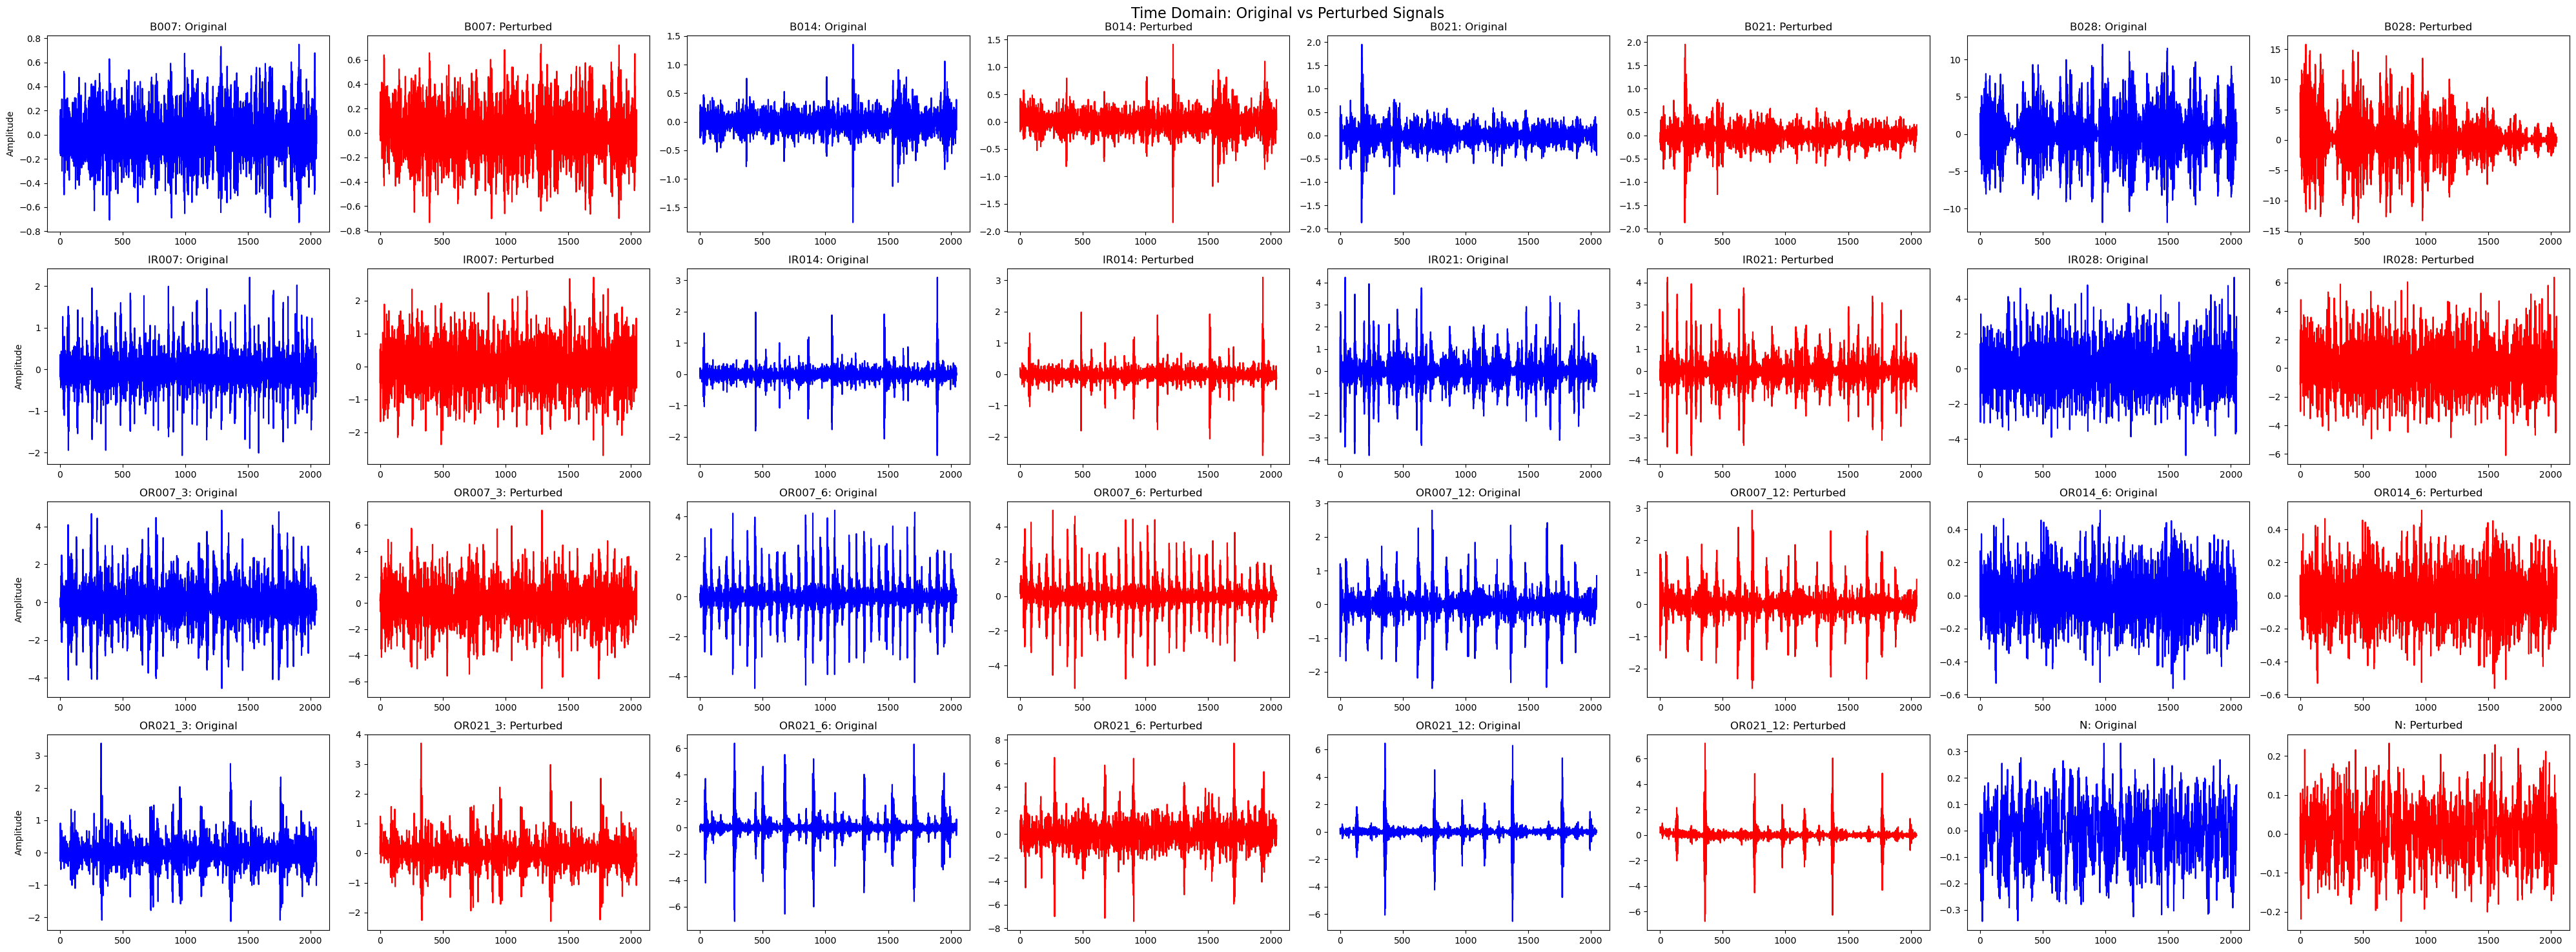

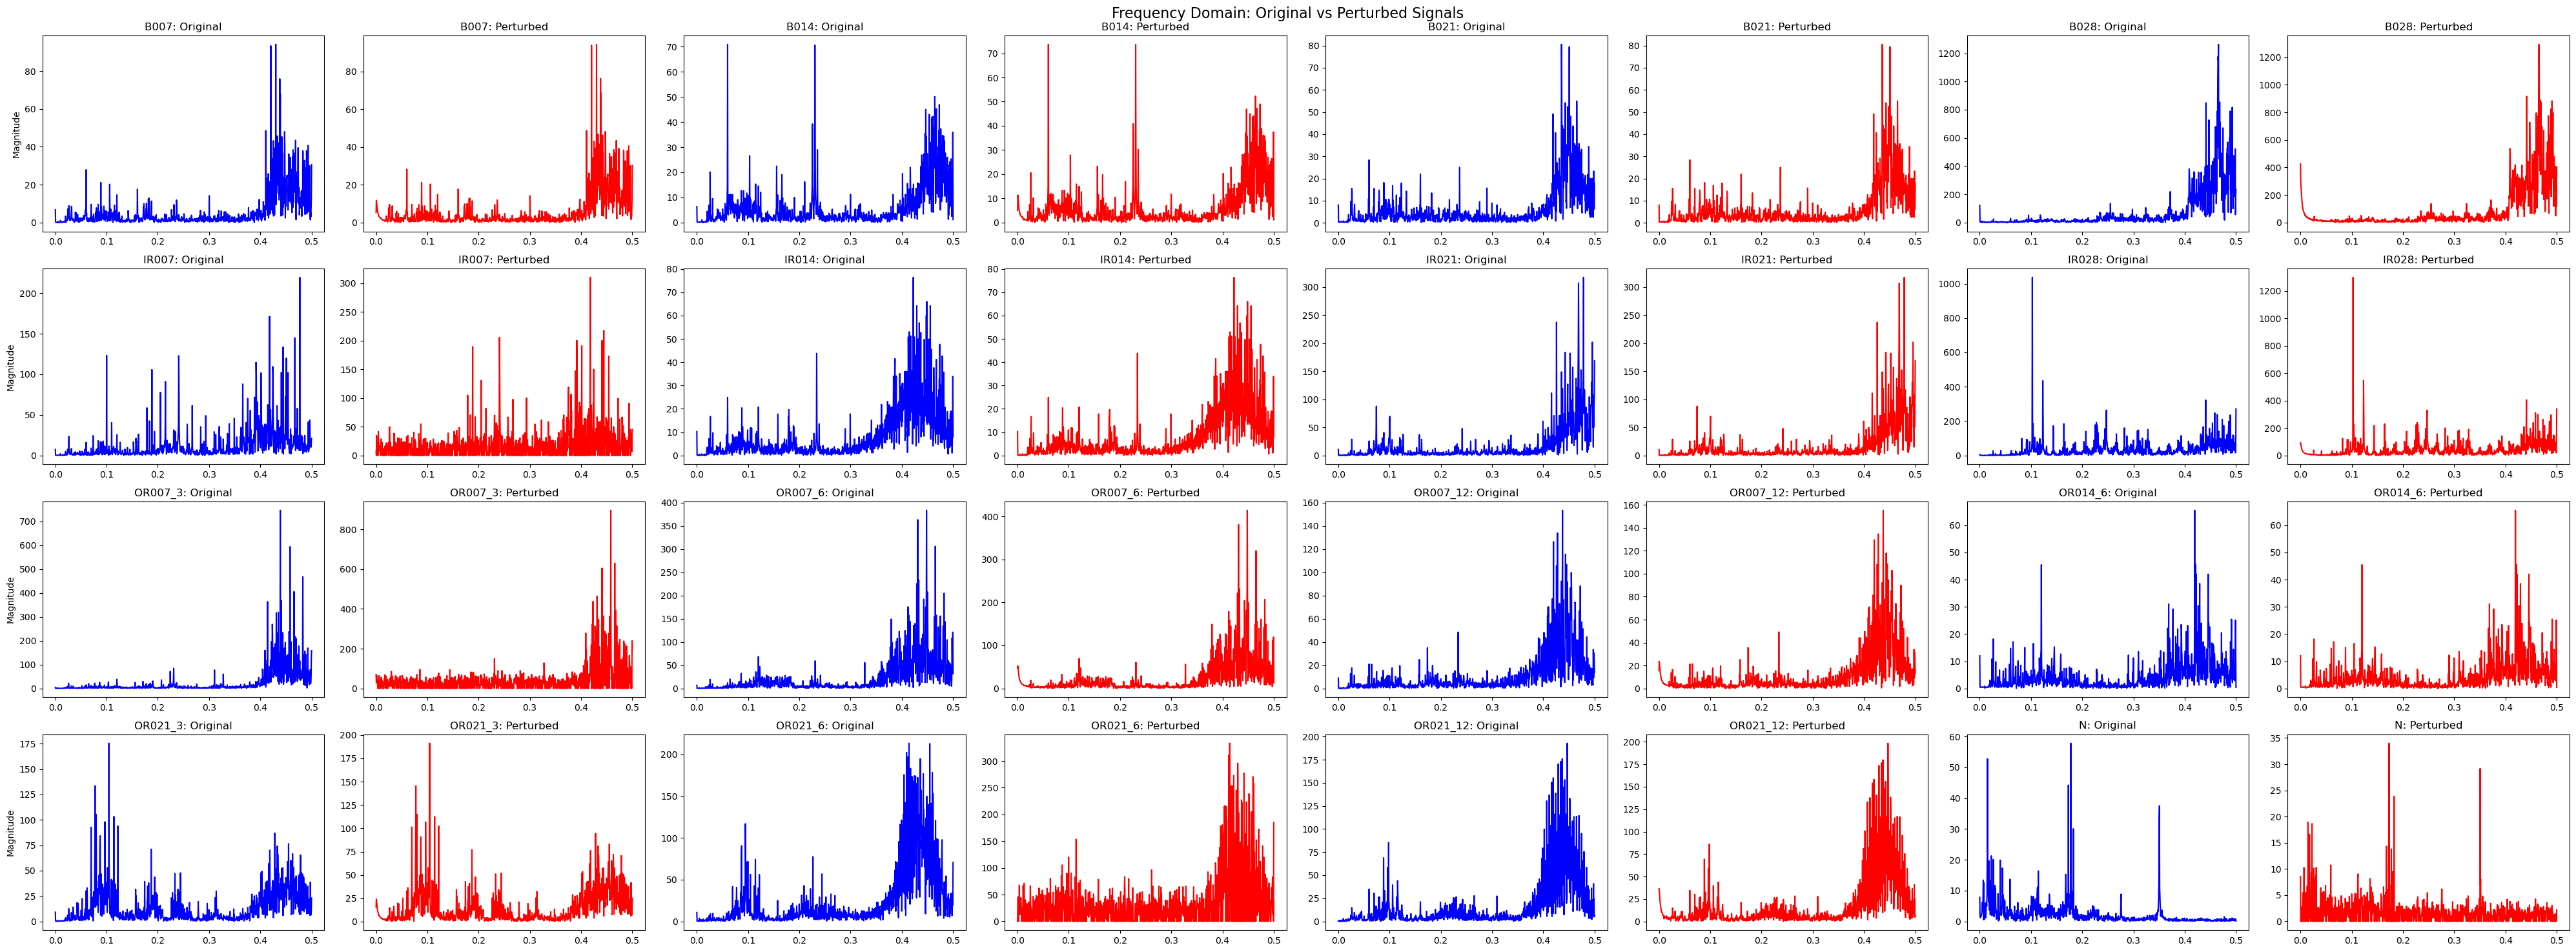

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the perturbation class
perturbation = TimeSeriesPerturbation()

# Create figures: one for time domain and one for frequency domain
fig_time = plt.figure(figsize=(40, 15))
fig_freq = plt.figure(figsize=(40, 15))

class_names = dataset.label_code
num_classes = len(class_names)
rows_needed = int(np.ceil(num_classes / 4))

# For each class, find a sample and plot
for class_idx, class_name in enumerate(class_names):
    # Find a sample with the current class
    found_sample = False
    for i in range(len(dataset)):
        data, label, _ = dataset[i]
        if torch.argmax(label).item() == class_idx:
            sample_data = data
            found_sample = True
            break
    
    if not found_sample:
        continue
    
    # Apply perturbation
    sample_batch = sample_data.unsqueeze(0)
    combined_signal = perturbation(sample_batch,).squeeze(0).numpy()
    original_signal = sample_data.numpy()
    
    # Calculate subplot positions (4 classes per row, each with original and perturbed)
    row = class_idx // 4
    col = class_idx % 4
    pos_orig = row * 8 + col * 2 + 1
    pos_pert = row * 8 + col * 2 + 2
    
    # Plot time domain signals (first channel only)
    channel = 0
    
    # Time domain plots
    ax_time_orig = fig_time.add_subplot(rows_needed, 8, pos_orig)
    ax_time_orig.plot(original_signal[:, channel], 'b-')
    ax_time_orig.set_title(f'{class_name}: Original')
    if col == 0:  # Only add y-label for the first column
        ax_time_orig.set_ylabel('Amplitude')
    
    ax_time_pert = fig_time.add_subplot(rows_needed, 8, pos_pert)
    ax_time_pert.plot(combined_signal[:, channel], 'r-')
    ax_time_pert.set_title(f'{class_name}: Perturbed')
    
    # Compute frequency domain
    sample_rate = 1.0  # Assuming normalized frequency
    freq_orig = np.abs(np.fft.rfft(original_signal[:, channel]))
    freq_perturbed = np.abs(np.fft.rfft(combined_signal[:, channel]))
    freqs = np.fft.rfftfreq(len(original_signal[:, channel]), d=1/sample_rate)
    
    # Frequency domain plots
    ax_freq_orig = fig_freq.add_subplot(rows_needed, 8, pos_orig)
    ax_freq_orig.plot(freqs[:], freq_orig[:], 'b-')
    ax_freq_orig.set_title(f'{class_name}: Original')
    if col == 0:  # Only add y-label for the first column
        ax_freq_orig.set_ylabel('Magnitude')
    
    ax_freq_pert = fig_freq.add_subplot(rows_needed, 8, pos_pert)
    ax_freq_pert.plot(freqs[:], freq_perturbed[:], 'r-')
    ax_freq_pert.set_title(f'{class_name}: Perturbed')

# Finalize time domain plot
fig_time.tight_layout()
plt.figure(fig_time.number)
plt.suptitle("Time Domain: Original vs Perturbed Signals", fontsize=16)
plt.subplots_adjust(top=0.95)

# Finalize frequency domain plot
fig_freq.tight_layout()
plt.figure(fig_freq.number)
plt.suptitle("Frequency Domain: Original vs Perturbed Signals", fontsize=16)
plt.subplots_adjust(top=0.95)

plt.show()


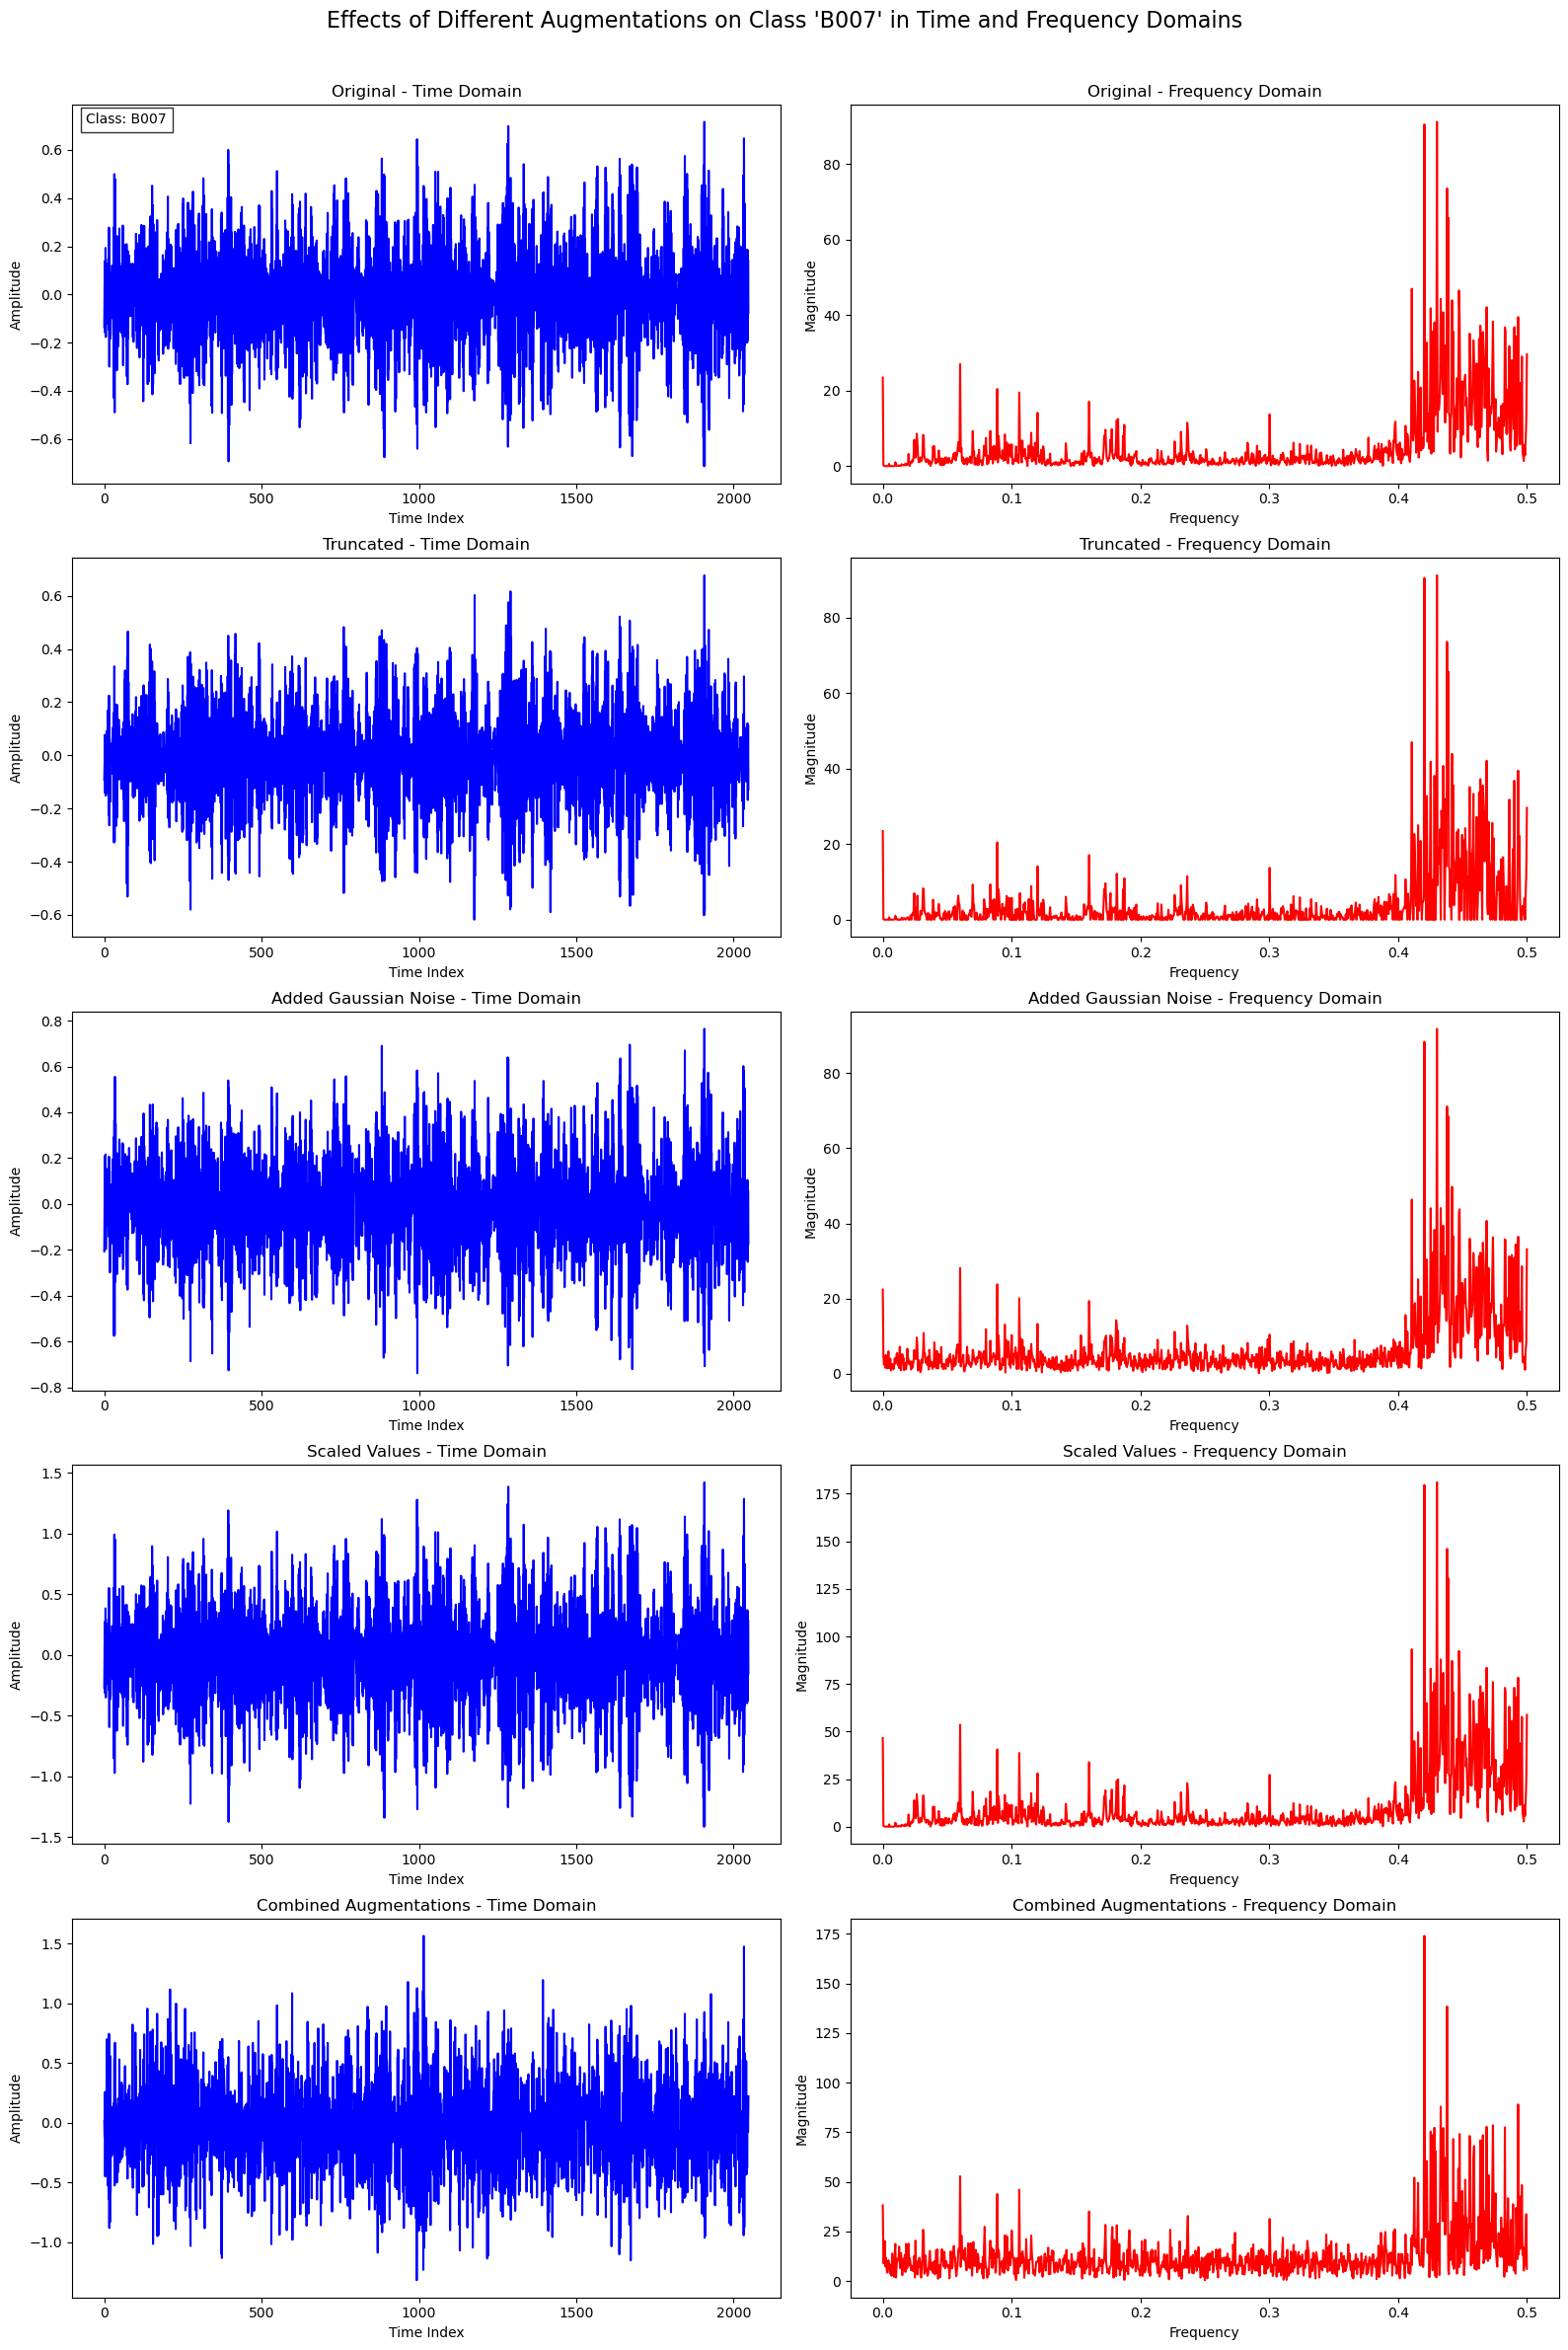

In [50]:
import numpy as np
import torch

import matplotlib.pyplot as plt

# Select a specific class sample for visualization
class_to_visualize = 'B007'  # You can change this to any class in class_names
class_idx = class_names[class_to_visualize]

# Find a sample with the selected class
for i in range(len(dataset)):
    data, label, _ = dataset[i]
    if torch.argmax(label).item() == class_idx:
        sample_data = data
        break
perturbation = TimeSeriesAugmentation()

# Convert to batch form for augmentation
sample_batch = sample_data.unsqueeze(0)
original_signal = sample_data.numpy()

# Apply each augmentation separately
truncated = perturbation.truncate(sample_batch).squeeze(0).numpy()
noisy = perturbation.add_gaussian_noise(sample_batch).squeeze(0).numpy()
scaled = perturbation.scale_values(sample_batch).squeeze(0).numpy()

# Apply all augmentations sequentially
combined_batch = sample_batch.clone()
combined_batch = perturbation.truncate(combined_batch)
combined_batch = perturbation.add_gaussian_noise(combined_batch)
combined_batch = perturbation.scale_values(combined_batch)
combined_signal = combined_batch.squeeze(0).numpy()

# Create subplots for time and frequency domains
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
plt.subplots_adjust(hspace=0.4)

titles = ['Original', 'Truncated',  'Added Gaussian Noise', 
          'Scaled Values',  'Combined Augmentations']
signals = [original_signal, truncated, noisy, scaled, combined_signal]

# Visualization parameters
channel = 0  # First channel
time_steps = 2048  # Show first 200 time steps for clarity
sample_rate = 1.0  # Assuming normalized frequency
max_freq = 2048  # Show first  frequency components

for i, (signal, title) in enumerate(zip(signals, titles)):
    # Time domain plot
    axs[i, 0].plot(signal[:time_steps, channel], 'b-')
    axs[i, 0].set_title(f"{title} - Time Domain")
    axs[i, 0].set_xlabel('Time Index')
    axs[i, 0].set_ylabel('Amplitude')
    
    # Frequency domain plot
    freq_signal = np.abs(np.fft.rfft(signal[:, channel]))
    freqs = np.fft.rfftfreq(len(signal[:, channel]), d=1/sample_rate)
    
    axs[i, 1].plot(freqs[:max_freq], freq_signal[:max_freq], 'r-')
    axs[i, 1].set_title(f"{title} - Frequency Domain")
    axs[i, 1].set_xlabel('Frequency')
    axs[i, 1].set_ylabel('Magnitude')
    
    # Add annotations
    if i == 0:
        axs[i, 0].text(0.02, 0.95, f"Class: {class_to_visualize}", transform=axs[i, 0].transAxes,
                        bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle(f"Effects of Different Augmentations on Class '{class_to_visualize}' in Time and Frequency Domains", 
             fontsize=16, y=0.99)
plt.subplots_adjust(top=0.95)
plt.show()